# OCR (optical character recognition) with Keras and TensorFlow

Author: [Dennis W. Hallema](https://www.linkedin.com/in/dennishallema) 

Description: Feed forward neural network to perform fast optical character recognition (OCR). This model can be used in OCR tasks with more complex text density, structure, fonts, script, artifact and text location. 

Depends: See `environment.yml`.

Data: MNIST (Modified National Institute of Standards and Technology) database of handwritten digits

Disclaimer: Use at your own risk. No responsibility is assumed for a user's application of these materials or related materials. 

In [1]:
# Import modules
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Print data type
print('x_train: %s\ny_train: %s' % (type(x_train), type(y_train)))
print('x_test: %s\ny_test: %s' % (type(x_test), type(y_test)))

x_train: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
x_test: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>


In [3]:
# Print data shape
print('x_train: %s\ny_train: %s' % (x_train.shape, y_train.shape))
print('x_test: %s\ny_test: %s' % (x_test.shape, y_test.shape))

# Print number of array dimensions
print('x_train: %s\ny_train: %s' % (x_train.ndim, y_train.ndim))
print('x_test: %s\ny_test: %s' % (x_test.ndim, y_test.ndim))

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)
x_train: 3
y_train: 1
x_test: 3
y_test: 1


The training set (above) contains 60,000 two-dimensional arrays of 28 x 28 elements (x_train), and each array is labeled (y_train). The testing set contains 10,000 two-dimensional arrays (x_test) that are also labeled (y_test).

In [4]:
# Print data type of array items
print('x_train: %s\ny_train: %s' % (x_train.dtype, y_train.dtype))
print('x_test: %s\ny_test: %s' % (x_test.dtype, y_test.dtype))

# Print min and max of array items
print('x_train: %s %s\ny_train: %s %s' % (np.amin(x_train), np.amax(x_train), np.amin(y_train), np.amax(y_train)))
print('x_test: %s %s\ny_test: %s %s' % (np.amin(x_test), np.amax(x_test), np.amin(y_test), np.amax(y_test)))

x_train: uint8
y_train: uint8
x_test: uint8
y_test: uint8
x_train: 0 255
y_train: 0 9
x_test: 0 255
y_test: 0 9


All arrays contain 8-bit unsigned integers, and each array item can code up to 256 ($2^{8}$) unique values between 0 and 255. The *x*-variable occupies the full range, and this is typical of 8-bit single-layer raster images. The *y*-variable contains values ranging between 0 and 9. These values are the labels we need to calibrate and validate the model.

In [5]:
# Define variables
img_res = (28, 28)
img_size = np.prod(img_res)
img_max = np.amax(x_train)
img_min = np.amin(x_train)
x_train_n = x_train.shape[0]
x_test_n = x_test.shape[0]

# Print
print(img_res)
print(img_size)
print(img_max)
print(img_min)
print(x_train_n)
print(x_test_n)

(28, 28)
784
255
0
60000
10000


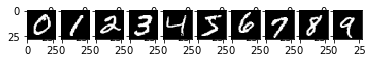

In [6]:
# Plot first occurrence of each digit
fig, ax = plt.subplots(1,10)
for i, ax in enumerate(ax.flatten()):
    img_i = np.argwhere(y_train == i)[0]
    plottable_image = np.reshape(x_train[img_i], img_res)
    ax.imshow(plottable_image, cmap = 'gray')

These are the first occurrences of each unique digit (above). The database contains thousands of handwritten digits that we can plot on a 28 $\times$ 28 pixel raster. Here is another example for comparison, note that the writing looks different (below).

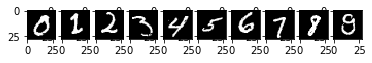

In [7]:
# Plot tenth occurrence of each digit
fig, ax = plt.subplots(1,10)
for i, ax in enumerate(ax.flatten()):
    img_i = np.argwhere(y_train == i)[9]
    plottable_image = np.reshape(x_train[img_i], img_res)
    ax.imshow(plottable_image, cmap = 'gray')

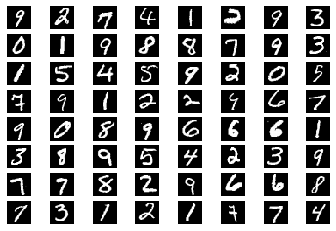

In [8]:
# Plot a random set of digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plottable_image = np.reshape(x_train[random.randint(0, x_train.shape[0])], img_res)
    ax.imshow(plottable_image, cmap = 'gray')

All image and image labels are in unsigned integer format. While there are models available that accept integers, these are often specialized applications running on dedicated hardware. Our neural network accepts data in floating-point format, so type conversion is necessary (below). We also normalize the image data to a range $(0,1)$ by dividing all arrays by ($2^{8}-1=255$). The purpose of normalization is two-fold: 

* First, the output of each node in a feed forward neural network is calculated by the activation function as the sum of weighted inputs. The weights can be positive or negative. Normalization ensures there are both positive and negative values available as inputs for the next layer, and leads to faster convergence. 

* Second, normalization also ensures that the scale (range between minimum and maximum values) *of node outputs* are comparable across different nodes. This makes that the learning process is better divided among the nodes.

In [9]:
# Cast images to float and normalize
x_train = x_train.reshape(x_train_n, img_size).astype('float32') / img_max
x_test = x_test.reshape(x_test_n, img_size).astype('float32') / img_max

# Cast labels to float
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

We have now created a training dataset and a test dataset. We also need a validation dataset. Each dataset serves a different purpose: 

* Training dataset: Data used to fit the model. 

* Validation dataset: Data used to evaluate model fit on the training dataset during calibration. 

* Test dataset: Hold-out data used to calculate a unbiased estimate of final model performance. 

In [10]:
# Create validation set
x_val = x_train[-x_test_n:]
y_val = y_train[-x_test_n:]
x_train = x_train[:-x_test_n]
y_train = y_train[:-x_test_n]

## Keras feed forward neural network

In this section we use Keras, the easy-to-use interface, to build a TensorFlow neural network.

In [11]:
# Import modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend

In [12]:
# Build model
model_1 = Sequential()
model_1.add(Dense(64, activation = 'relu', input_shape = (img_size,)))
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(10, activation = 'softmax'))

# Compile model
model_1.compile(optimizer = keras.optimizers.Adam(), 
              loss = keras.losses.SparseCategoricalCrossentropy(), 
              metrics = [keras.metrics.SparseCategoricalAccuracy()])

# Fit model
history = model_1.fit(x_train, y_train, batch_size = 256, epochs = 10,
                   validation_data = (x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 31us/sample - loss: 0.5722 - sparse_categorical_accuracy: 0.8409 - val_loss: 0.2377 - val_sparse_categorical_accuracy: 0.9331
Epoch 2/10
50000/50000 [==============================] - 1s 15us/sample - loss: 0.2255 - sparse_categorical_accuracy: 0.9357 - val_loss: 0.1760 - val_sparse_categorical_accuracy: 0.9505
Epoch 3/10
50000/50000 [==============================] - 1s 16us/sample - loss: 0.1716 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1553 - val_sparse_categorical_accuracy: 0.9582
Epoch 4/10
50000/50000 [==============================] - 1s 16us/sample - loss: 0.1388 - sparse_categorical_accuracy: 0.9597 - val_loss: 0.1259 - val_sparse_categorical_accuracy: 0.9650
Epoch 5/10
50000/50000 [==============================] - 1s 17us/sample - loss: 0.1160 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1161 - val_sparse_categorical_accuracy: 0.9666
Epoch 6/10
5000

In [13]:
# Evaluate model for 10 samples
results = model_1.evaluate(x_test, y_test, batch_size = 256)
predictions = model_1.predict(x_test[:10])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


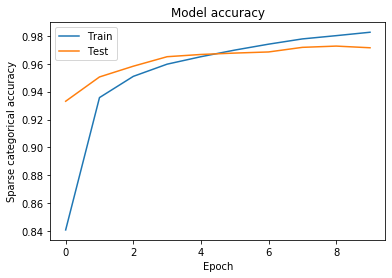

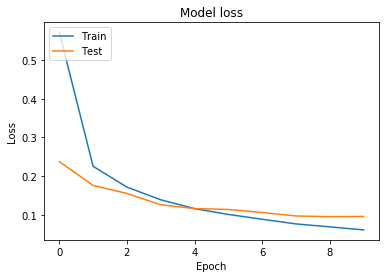

In [14]:
# Print callback keys
print(history.history.keys())

# Plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Sparse categorical accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Keras models use the TensorFlow back-end and can be deployed in production workflows. The two-hidden layer feed forward neural network we created in Keras (see above) is highly accurate (>98% on training data and >96% on testing data). Calculations are fast, and even a relatively large batch size of 256 samples yields good training stability and performance power. Let's see if we can do even better.

## TensorFlow feed forward neural network

Keras uses the TensorFlow back-end that offers many model options. Using the above Keras model as an example, we will now build a TensorFlow model with 128 nodes per hidden layer instead of 64. Furthermore, we will use the RMSprop gradient descent optimization algorithm instead of Adam. 

* Adam (Adaptive Moment Estimation) is a popular optimization algorithm, possibly because it is computationally efficient and requires little memory. The adaptive learning rate for each parameter is calculated from estimates of first and second moments of the descent gradients, and has the tendency to gain momentum in stationary optimization problems. We used Adam when we trained the Keras model (previous section) because we wanted the highest model performance possible for a large batch size and small number of epochs.

* RMSprop is likewise an adaptive optimization algorithm, but instead uses a moving average of the squared gradient (viz. the most recent gradient descents) to optimize the hyperparameters. This algorithm moves slower, but is more accurate in non-stationary problems. We will use RMSprop to fine-tune the TensorFlow model with a smaller batch size and more epochs (below).

The code syntax of TensorFlow is slightly different. 

In [15]:
# Import modules
from tensorflow.keras import layers

In [16]:
# Build model
inputs = keras.Input(shape = (img_size,), name = 'digits')
x = layers.Dense(128, activation = 'relu', name = 'dense_1')(inputs)
x = layers.Dense(128, activation = 'relu', name = 'dense_2')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'predictions')(x)
model_2 = keras.Model(inputs = inputs, outputs = outputs)

# Compile model
model_2.compile(optimizer = keras.optimizers.RMSprop(), 
              loss = keras.losses.SparseCategoricalCrossentropy(), 
              metrics = [keras.metrics.SparseCategoricalAccuracy()])

# Train model
history = model_2.fit(x_train, y_train, batch_size = 128, epochs = 30,
                validation_data = (x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 3s 53us/sample - loss: 0.3299 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.1655 - val_sparse_categorical_accuracy: 0.9524
Epoch 2/30
50000/50000 [==============================] - 2s 37us/sample - loss: 0.1403 - sparse_categorical_accuracy: 0.9577 - val_loss: 0.1175 - val_sparse_categorical_accuracy: 0.9660
Epoch 3/30
50000/50000 [==============================] - 2s 36us/sample - loss: 0.0961 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.1013 - val_sparse_categorical_accuracy: 0.9712
Epoch 4/30
50000/50000 [==============================] - 2s 31us/sample - loss: 0.0705 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0946 - val_sparse_categorical_accuracy: 0.9735
Epoch 5/30
50000/50000 [==============================] - 2s 39us/sample - loss: 0.0557 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.9736
Epoch 6/30
5000

In [17]:
# Evaluate model for 10 samples
results = model_2.evaluate(x_test, y_test, batch_size = 128)
predictions = model_2.predict(x_test[:10])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


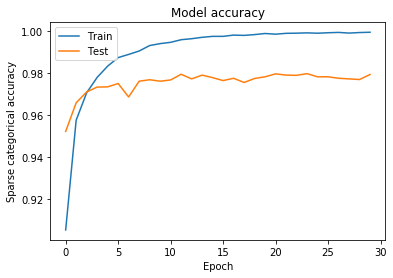

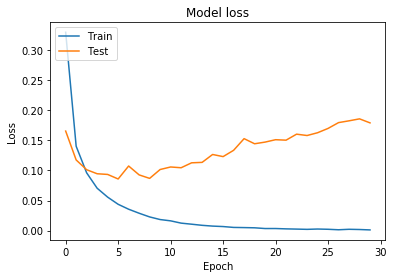

In [18]:
# Print callback keys
print(history.history.keys())

# Plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Sparse categorical accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The result is an efficient feed forward neural network TensorFlow model that delivers high accuracy (>99.9% on training data and >97% on testing data) within a slightly longer computation time than for the Keras model. The RMSprop calculations are comparatively time-consuming, and in this particular TensorFlow model we obtained good results by combining a large batch size (128) with a large number of epochs (30). A large batch size means that the gradient is calculated less often, and therefore 30 epochs do not take much computating time. 

Even higher accuracy is possible by adding more hidden layers (i.e. a "deeper" feed forward neural network), or by using a convolutional neural network. Convolutional networks use convolution (linear transformation) in at least one of their layers, where feed forward neural networks use matrix multiplication only. Convolutional neural networks are generally better adapted to visual imagery, because pattern agreements can be partially expressed as translations in the visual space.  